In [1]:
import numpy as np


def ensemble_kalman_filter(f, h, x_ens, y_obs, R, Q=None):
    """
    Perform one EnKF update step.

    Parameters:
    - f: function to propagate the state (model dynamics)
    - h: function to map state to observation (measurement function)
    - x_ens: np.ndarray of shape (n_ens, n_state), ensemble of states
    - y_obs: np.ndarray of shape (n_obs,), observation vector
    - R: np.ndarray of shape (n_obs, n_obs), observation noise covariance
    - Q: np.ndarray of shape (n_state, n_state), process noise covariance (optional)

    Returns:
    - x_ens_updated: np.ndarray, updated ensemble
    """
    n_ens = x_ens.shape[0]

    # Forecast Step
    for i in range(n_ens):
        x_ens[i] = f(x_ens[i])
        if Q is not None:
            x_ens[i] += np.random.multivariate_normal(np.zeros(Q.shape[0]), Q)

    # Observation predictions
    y_ens = np.array([h(x) for x in x_ens])
    y_mean = np.mean(y_ens, axis=0)
    x_mean = np.mean(x_ens, axis=0)

    # Covariances
    X_prime = x_ens - x_mean
    Y_prime = y_ens - y_mean
    P_xy = (X_prime.T @ Y_prime) / (n_ens - 1)
    P_yy = (Y_prime.T @ Y_prime) / (n_ens - 1) + R

    # Kalman gain
    K = P_xy @ np.linalg.inv(P_yy)

    # Update Step
    for i in range(n_ens):
        y_perturbed = y_obs + np.random.multivariate_normal(np.zeros(R.shape[0]), R)
        x_ens[i] += K @ (y_perturbed - y_ens[i])

    return x_ens

In [2]:
# Define model and observation functions
f = lambda x: 0.5 * x + 2  # Example model dynamics
h = lambda x: x  # Direct observation

# Initial ensemble
n_ens = 100
x_ens = np.random.normal(loc=0, scale=1, size=(n_ens, 1))

# Observation
y_obs = np.array([3.5])

# Covariances
R = np.array([[0.1]])
Q = np.array([[0.05]])

# Run EnKF
x_ens_updated = ensemble_kalman_filter(f, h, x_ens, y_obs, R, Q)

# Ensemble mean (state estimate)
x_estimate = np.mean(x_ens_updated, axis=0)
print("Posterior Mean:", x_estimate)

Posterior Mean: [3.1411074]


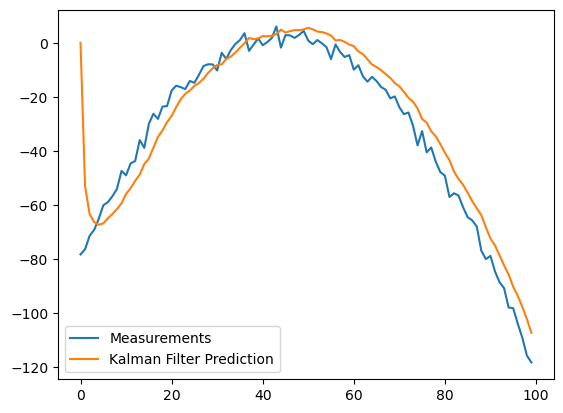

In [1]:
import numpy as np


class KalmanFilter(object):
    def __init__(self, F=None, B=None, H=None, Q=None, R=None, P=None, x0=None):

        if F is None or H is None:
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u=0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(
            np.dot(I - np.dot(K, self.H), self.P), (I - np.dot(K, self.H)).T
        ) + np.dot(np.dot(K, self.R), K.T)


def example():
    dt = 1.0 / 60
    F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
    H = np.array([1, 0, 0]).reshape(1, 3)
    Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
    R = np.array([0.5]).reshape(1, 1)

    x = np.linspace(-10, 10, 100)
    measurements = -(x**2 + 2 * x - 2) + np.random.normal(0, 2, 100)

    kf = KalmanFilter(F=F, H=H, Q=Q, R=R)
    predictions = []

    for z in measurements:
        predictions.append(np.dot(H, kf.predict())[0])
        kf.update(z)

    import matplotlib.pyplot as plt

    plt.plot(range(len(measurements)), measurements, label="Measurements")
    plt.plot(
        range(len(predictions)), np.array(predictions), label="Kalman Filter Prediction"
    )
    plt.legend()
    plt.show()


if __name__ == "__main__":
    example()

In [13]:
import numpy as np
from numpy.linalg import inv
from numpy import dot, sum, tile, linalg
from numpy.linalg import inv 

def kf_predict(X, P, A, Q, B, U):
    X = dot(A, X) + dot(B, U)
    P = dot(A, dot(P, A.T)) + Q
    return(X,P) 

def kf_update(X, P, Y, H, R):
    IM = dot(H, X)
    IS = R + dot(H, dot(P, H.T))
    K = dot(P, dot(H.T, inv(IS)))
    X = X + dot(K, (Y-IM))
    P = P - dot(K, dot(IS, K.T))
    LH = gauss_pdf(Y, IM, IS)
    return (X,P,K,IM,IS,LH)

def gauss_pdf(X, M, S):
    if M.shape[1] == 1:
        DX = X - tile(M, X.shape[1])
        E = 0.5 * sum(DX * (dot(inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    elif X.shape[1] == 1:
        DX = tile(X, M.shape[1]) - M
        E = 0.5 * sum(DX * (dot(inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    else:
        DX = X - M
        E = 0.5 * dot(DX.T, dot(inv(S), DX))
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    return (P[0], E[0])


# time step of mobile movement
dt = 0.1
# Initialization of state matrices
X = np.array([[0.0], [0.0], [0.1], [0.1]])
P = np.diag((0.01, 0.01, 0.01, 0.01))
A = np.array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
Q = np.eye(X.shape[0])
B = np.eye(X.shape[0])
U = np.zeros((X.shape[0],1)) 

# Measurement matrices
Y = np.array([[X[0,0] + abs(np.random.randn(1)[0])], [X[1,0] + abs(np.random.randn(1)[0])]])
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = np.eye(Y.shape[0])
# Number of iterations in Kalman Filter
N_iter = 50

traj_estimate = []
traj_measure = []
# Applying the Kalman Filter
for i in np.arange(0, N_iter):
    (X, P) = kf_predict(X, P, A, Q, B, U)
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
    Y = np.array([[X[0,0] + abs(0.1 * np.random.randn(1)[0])],[X[1, 0] + abs(0.1 * np.random.randn(1)[0])]]) 
    
    traj_estimate.append(X)
    traj_measure.append(Y)

In [16]:
traj_measure = np.concatenate(traj_measure, axis = 1).T
traj_estimate = np.concatenate(traj_estimate, axis = 1).T

In [20]:
traj_estimate = (H@traj_estimate.T).T

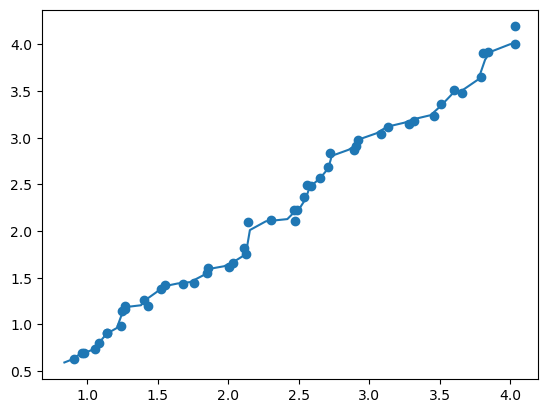

In [21]:
import matplotlib.pyplot as plt

plt.scatter(traj_measure[:,0], traj_measure[:,1], label = "Measured trajectory")
plt.plot(traj_estimate[:,0], traj_estimate[:,1], label = "Estimated trajectory")